![](https://drive.google.com/uc?id=1tbAZJ-itbJGUkQHS76xw91PO-8juW75y)
<br>
<sub>Ref: [Siamese Neural Networks for One-shot Image Recognition Research Paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)</sub>

# Facial Verification

--------------
## **Description**
--------------

This exercise involves implementing a model described in a research paper and integrating it into an application.




In [ ]:
#!pip install tensorflow==2.16.1 tensorflow-gpu==2.12 opencv-python matplotlib

In [1]:
!pip install visualkeras
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 971.8 kB/s eta 0:00:00


## Import Dependencies

In [2]:
# import standard dependencies
import cv2
import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil_image
from IPython.display import Image, display, Javascript, HTML
import ipywidgets as widgets
from google.colab import output
from google.colab.output import eval_js
import base64

import visualkeras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# import the uuid library to generate unique image names
import uuid

In [3]:
# import tensorflow dependencies - Functional API
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## Set GPU Growth

In [4]:
# avoid out of memory (OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures

In [5]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/Facial Recongnition'

In [6]:
# setup paths
POS_PATH = os.path.join(ROOT, 'data', 'positive')
NEG_PATH = os.path.join(ROOT, 'data', 'negative')
ANC_PATH = os.path.join(ROOT, 'data', 'anchor')

In [ ]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positives And Anchors

## Untar Labelled Faces in the Wild Dataset

In [ ]:
# uncompress TAR GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor Classes

In [231]:
def save_image(image_data, full_file_path):
  try:
    # Decode the base64-encoded image data
    binary = base64.b64decode(image_data)

    # Load the image directly as a NumPy array
    image_array = cv2.imdecode(np.frombuffer(binary, dtype=np.uint8), cv2.IMREAD_COLOR)

    # Process the image
    processed_image = crop_square(image_array, 250)

    # Save the processed image to a file
    cv2.imwrite(full_file_path, processed_image)
    return True
  except Exception as e:
    print(f'Error saving image: {e}')
    return False

output.register_callback('notebook.save_image', save_image)

In [246]:
def take_photo(dir, generate_file_name=True, quality=0.8, verification_callback=None, capture_btn_name='Capture'):

  if generate_file_name:
    # name the new file with unique identifier
    full_file_path = os.path.join(dir, f"{uuid.uuid1()}.jpg")
  else:
    full_file_path = dir

  # create javascript function
  js = Javascript('''
     async function takePhoto(full_file_path, quality, verification_callback, capture_btn_name) {

      // create shell with div and capture button
      const div = document.createElement('div');
      div.style.padding = '10px';

      // create capture button
      const capture = document.createElement('button');
      capture.textContent = capture_btn_name;
      capture.style.marginRight = '10px';
      div.appendChild(capture);

      // create close button
      const close = document.createElement('button')
      close.textContent = 'Close';
      div.appendChild(close);

      // create video space
      const video = document.createElement('video');
      video.style.display = 'block';

      // add video block to div
      div.appendChild(video);

      // create video element
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // add dive to the body
      document.body.appendChild(div);

      // set the source and play the media
      video.srcObject = stream;
      await video.play();

      // resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      capture.onclick = async () => {
          // create a canvas element to draw the video frame
          const canvas = document.createElement('canvas');

          // set the canvas width and height to match the video dimensions
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;

          // draw the current video frame onto the canvas
          canvas.getContext('2d').drawImage(video, 0, 0);

          // Convert the canvas content to a base64-encoded JPEG image data URL
          // with the specified quality
          const dataUrl = canvas.toDataURL('image/jpeg', quality);

          // Split the data URL to extract the base64-encoded image data
          const imageData = dataUrl.split(',')[1];

          // Send the base64-encoded image data to Python
          const is_saved = await google.colab.kernel.invokeFunction('notebook.save_image', [imageData, full_file_path], {});

          // If the verification callback is provided, invoke it
          if(is_saved.data && verification_callback !== undefined){
            const result = await google.colab.kernel.invokeFunction(verification_callback, [], {});
            console.log(result);
          }

          return is_saved.data;
      };

      close.onclick = () => {
          // stop the video stream to release resources
          stream.getVideoTracks()[0].stop();

          // remove the video element and its containing div from the DOM
          div.remove();
      };
    }
    ''')

  # create and display the javascript function
  display(js)

  # call the javascript function
  display(Javascript(f'takePhoto("{full_file_path}", "{quality}", "{verification_callback}", "{capture_btn_name}")'))

In [9]:
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = min(h, w)

    # Centralize and crop
    center_x, center_y = w // 2, h // 2
    half_size = min_size // 2
    crop_img = img[center_y - half_size:center_y + half_size, center_x - half_size:center_x + half_size]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [10]:
def collect_images(anchor=True):
  root_data_dir = os.path.join(ROOT, 'data')

  dir = os.path.join(root_data_dir, 'anchor') if anchor else os.path.join(root_data_dir, 'positive')

  take_photo(dir)

In [11]:
def on_collect_anchors_clicked(b):
   collect_images(anchor=True)

def on_collect_positives_clicked(b):
   collect_images(anchor=False)

In [158]:
# create a collect button widgets
anchor_btn = widgets.Button(description="Collect Anchors")
positive_btn = widgets.Button(description="Collect Positives")

# assign the click events
anchor_btn.on_click(on_collect_anchors_clicked)
positive_btn.on_click(on_collect_positives_clicked)

# display the buttons side by side
display(widgets.HBox([anchor_btn, positive_btn]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load and Preprocess Images

## Get Image Directories

In [13]:
ANC_PATH = os.path.join(ANC_PATH, "*.jpg")
POS_PATH = os.path.join(POS_PATH, "*.jpg")
NEG_PATH = os.path.join(NEG_PATH, "*.jpg")

anchor = tf.data.Dataset.list_files(ANC_PATH).take(300)
positive = tf.data.Dataset.list_files(POS_PATH).take(300)
negative = tf.data.Dataset.list_files(NEG_PATH).take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [23]:
samp_img = dir_test.next()
samp_img

b'/content/drive/MyDrive/Colab Notebooks/Facial Recongnition/data/anchor/f1ef954a-f184-11ee-9701-0242ac1c000c.jpg'

## Preprocessing - Scale and Resize


![Siamese Neural Network Input](https://drive.google.com/uc?id=1ab0kjx29vhxQvFvwY5uHHrVYRWSOaZ-W)
<br>
<sub>Input to Siamese Neural Network</sub>


In [16]:
def preprocess(file_path):

  # read in image from file path
  byte_img = tf.io.read_file(file_path)
  # load in the image
  img = tf.io.decode_jpeg(byte_img)
  # preprocessing steps - resizing the image to be 100X100X3
  # this is because in the Siamese Neural Networks the input is 105
  img = tf.image.resize(img, (105, 105))
  # normalize pixel values to [0, 1]
  img = img / 255.0
  # returning image
  return img

In [24]:
img = preprocess(samp_img)

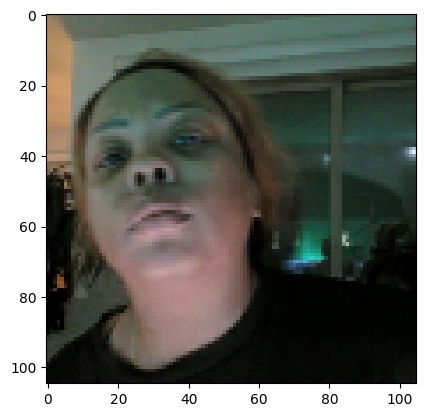

In [25]:
plt.imshow(img);

In [26]:
img.numpy().min(), img.numpy().max()

(0.0, 0.9829733)

## Create Labeled Dataset

In [164]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [27]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
samples = data.as_numpy_iterator()

In [29]:
example = samples.next()

In [30]:
example

(b'/content/drive/MyDrive/Colab Notebooks/Facial Recongnition/data/anchor/dec3f16e-f184-11ee-9701-0242ac1c000c.jpg',
 b'/content/drive/MyDrive/Colab Notebooks/Facial Recongnition/data/positive/f983c992-f185-11ee-9701-0242ac1c000c.jpg',
 1.0)

## Build Train and Test Partition

In [31]:
def preprocess_twin(input_img, validation_img, label):
  return (preprocess(input_img), preprocess(validation_img), label)

In [32]:
res = preprocess_twin(*example) # * unpacks the example and passes the parameters to preprocess_twin

In [33]:
res[0].shape, res[1].shape, res[2]

(TensorShape([105, 105, 3]), TensorShape([105, 105, 3]), 1.0)

In [34]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [38]:
samples = data.as_numpy_iterator()

In [101]:
samp = samples.next()

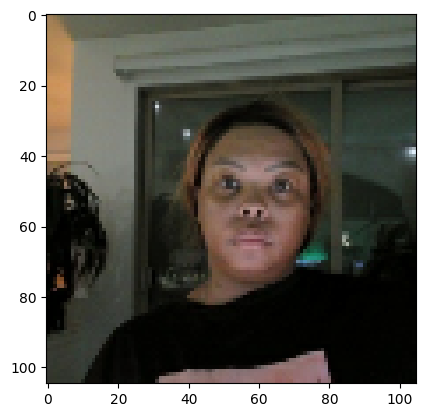

In [102]:
plt.imshow(samp[0])

0.0

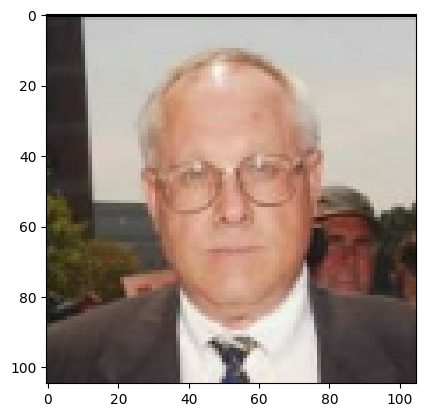

In [103]:
plt.imshow(samp[0]);
plt.imshow(samp[1]);
samp[2]

In [104]:
# training partition
training_data_length = round(len(data)*.7)
train_data = data.take(training_data_length)
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [105]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [106]:
# testing partition
test_data = data.skip(training_data_length)
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [107]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Model Engineering

## Build Embedding Layer

In [108]:
def make_embedding():
  inp = Input(shape=(105,105,3), name='input_image')

  # first block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # second block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # third block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # final embedding block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [109]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

![Siamese Neural Network Input](https://drive.google.com/uc?id=1Scq0nlGjzkT6fyB4hxUTt1bJSWs77rI8)
<br>
<sub>Siamese Neural Network Embedding Layer</sub>

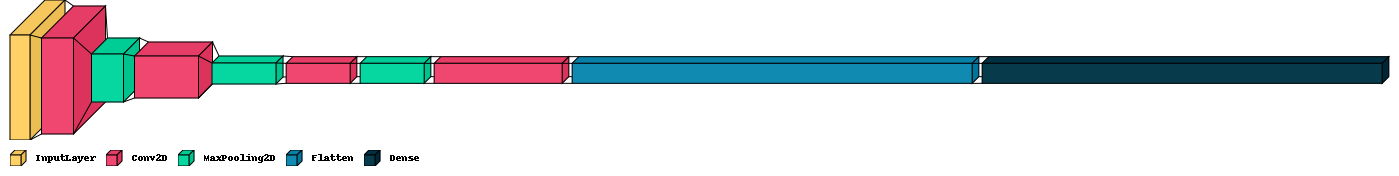

In [110]:
visualkeras.layered_view(embedding, legend=True, scale_xy=1, scale_z=0.5)

## Build Distance Layer

In [111]:
# Siamese L1 Distance class
class L1Dist(Layer):

  # init method - inheritance
  def __init__(self, **kwargs):
    super().__init__() # initialize the base

  # tells the layer what to do when data is passed to it
  # input_embedding is our first image embedding layer
  # validation_embedding is out second image embedding layer
  # return the abosolute value of the difference between the two
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

## Make Siamese Model

In [112]:
def make_siamese_model():

  # anchor image input in the network
  input_image = Input(name='input_img', shape=(105, 105, 3))

  # validation image input in the network
  validation_image = Input(name='validation_img', shape=(105, 105, 3))

  # combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'

  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # classifcation layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [113]:
siamese_model = make_siamese_model()

In [114]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

![Siamese Neural Network Input](https://drive.google.com/uc?id=1hDpgir-eCMDx8Gwd7DL2yxV2VeoZD7RO)
<br>
<sub>Siamese Neural Network</sub>

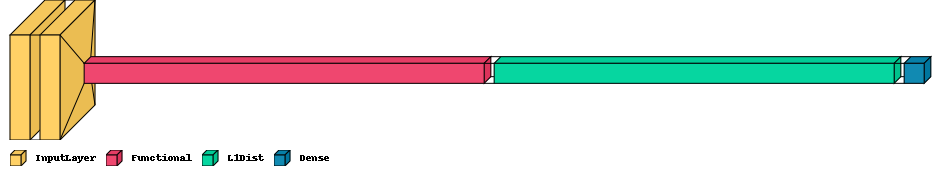

In [115]:
visualkeras.layered_view(siamese_model, legend=True, scale_xy=1, scale_z=0.5)

# Training

## Setup Loss and Optimizer

In [116]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [117]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4) #1e-4 == 0.0001

## Establish Checkpoints

In [118]:
checkpoint_dir = os.path.join(ROOT,'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train Step Function

In [119]:
@tf.function
def train_step(batch):

  # record all of our operations
  with tf.GradientTape() as tape:

    # get the anchor and positive/negative image
    X = batch[:2]

    # get label
    y = batch[2]

    # forward pass
    yhat = siamese_model(X, training=True)

    # calculate loss
    loss = binary_cross_loss(y, yhat)

  # print the loss
  tf.print("loss:", loss, output_stream=sys.stdout)

  # calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  # return the loss
  return loss

## Build Training Loop

In [120]:
def train(data, epochs):

  # loop through the epochs
  for epoch in range(1, epochs+1):
    print(f'\n Epoch {epoch}/{epochs}')
    progbar = tf.keras.utils.Progbar(len(data))

    # loop through each batch
    for idx, batch in enumerate(data):
      # run train step here
      epoch_loss = train_step(batch)
      progbar.update(idx+1)

    # save checkpoints every 10th epoch
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [121]:
EPOCHS = 50

In [122]:
train(train_data, EPOCHS)


 Epoch 1/50
loss: 0.687480807
27/27 [==============================] - 15s 243ms/step

 Epoch 2/50
loss: 0.100982159
27/27 [==============================] - 6s 205ms/step

 Epoch 3/50
loss: 0.00687480764
27/27 [==============================] - 6s 207ms/step

 Epoch 4/50
loss: 0.000639959355
27/27 [==============================] - 6s 207ms/step

 Epoch 5/50
loss: 0.0017475558
27/27 [==============================] - 6s 208ms/step

 Epoch 6/50
loss: 9.69086686e-05
27/27 [==============================] - 6s 209ms/step

 Epoch 7/50
loss: 0.000113418282
27/27 [==============================] - 6s 208ms/step

 Epoch 8/50
loss: 2.46552481e-05
27/27 [==============================] - 6s 208ms/step

 Epoch 9/50
loss: 0.00017228775
27/27 [==============================] - 6s 208ms/step

 Epoch 10/50
loss: 2.37349777e-05
27/27 [==============================] - 6s 208ms/step

 Epoch 11/50
loss: 7.2994837e-05
27/27 [==============================] - 6s 209ms/step

 Epoch 12/50
loss: 1.1984537

# Evaluate Model

## Import Metrics

In [123]:
# import metric calculations
from keras.metrics import Precision, Recall

## Make Predictions

In [135]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [125]:
# make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 148ms/step


array([[9.9999976e-01],
       [9.9999762e-01],
       [9.9999988e-01],
       [2.0920602e-08],
       [2.9696514e-07],
       [9.9999595e-01],
       [1.0000000e+00],
       [1.3941046e-08],
       [9.9999976e-01],
       [9.9999988e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [9.9999487e-01],
       [1.0000000e+00],
       [4.6231472e-09],
       [9.9999952e-01]], dtype=float32)

In [126]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [127]:
y_true

array([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

## Calculate Metrics

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        87
    positive       1.00      1.00      1.00        93

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



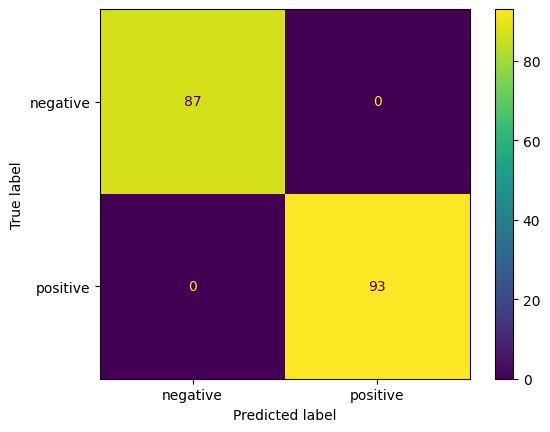

In [138]:
# initialize empty arrays to store predictions and true labels
y_hat = []
y_true = []

# iterate over batches of the test dataset
for anchor, val, label in test_data.as_numpy_iterator():

  # Concatenate true labels
  y_true = np.concatenate((y_true, label))

  # get predictions
  batch_predictions = siamese_model.predict([anchor, val], verbose=0)

  # append predictions
  y_hat.append(batch_predictions)

# Concatenate predictions
y_hat = np.concatenate(y_hat, axis=0)
y_hat = np.where(y_hat > 0.5, 1, 0)

# display classification report
print(classification_report(y_true, y_hat, target_names=['negative', 'positive']))

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_hat, display_labels=['negative', 'positive']);

## Visualize Results

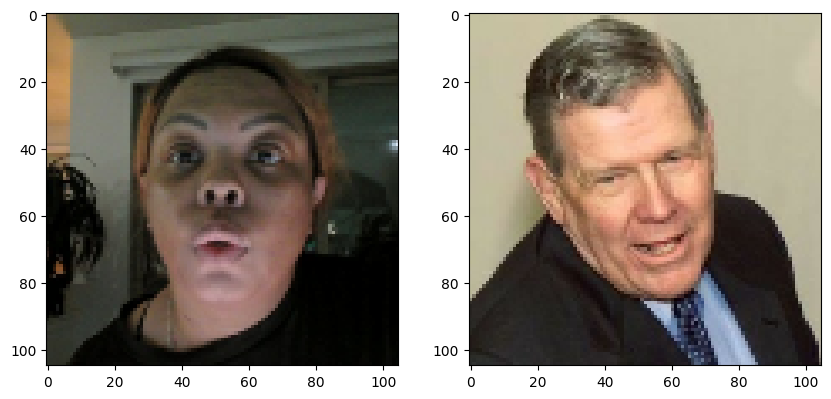

In [129]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[1])

plt.subplot(1, 2, 2)
plt.imshow(test_val[1])
plt.show();

## Save Model

In [130]:
file_name = os.path.join(ROOT, 'models', 'siamese_model.h5')

In [131]:
# save weights
siamese_model.save(file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [132]:
# reload model
model = tf.keras.models.load_model(file_name, custom_objects={'L1Dist':L1Dist,
                                                              'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [139]:
# make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 21ms/step


array([[2.4626374e-09],
       [9.9999976e-01],
       [1.0545193e-08],
       [9.9999857e-01],
       [1.0000000e+00],
       [9.9999964e-01],
       [9.9999988e-01],
       [9.9999952e-01],
       [1.6321472e-08],
       [1.0000000e+00],
       [9.9999464e-01],
       [4.4054178e-09],
       [9.9999964e-01],
       [9.9999690e-01],
       [4.4213016e-06],
       [9.9999976e-01]], dtype=float32)

In [140]:
# view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Time Test

## Verification Function

In [250]:
INPUT_IMAGE_NAME = 'input_image.jpg'
application_data_folder = os.path.join(ROOT, 'application_data')
input_img_folder = os.path.join(application_data_folder, 'input_image')
VERIFICATION_THREASHOLD = 0.7
DETECTION_THRESHOLD = 0.9

In [247]:
def verify():
  # build results array
  results = []

  print(f'Hold on verifying....')

  verification_images_folder = os.path.join(application_data_folder, 'verification_images')

  print(f'Predicting....')

  for image in os.listdir(verification_images_folder):
    input_img = preprocess(os.path.join(input_img_folder, INPUT_IMAGE_NAME))
    validation_img = preprocess(os.path.join(verification_images_folder, image))

    # make predictions
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)), verbose=0)
    results.append(result)

  print(f'Made predictions getting metrics....')
  # Detection Threshold: Metric above which a prediction is considered positive
  detection = np.sum(np.array(results) > DETECTION_THRESHOLD)

  # Verfication Threshold: Proportion of positive predictions / total positive samples
  verfication = detection / len(os.listdir(verification_images_folder))
  verified = verfication > VERIFICATION_THREASHOLD

  print(f'Verified: {verified}')

  return results, verified

output.register_callback('notebook.verify', verify)

## OpenCV Real Time Verification

In [251]:
# open camera and test verfication
imput_img_dir = os.path.join(input_img_folder, INPUT_IMAGE_NAME)

take_photo(imput_img_dir, generate_file_name=False, verification_callback='notebook.verify', capture_btn_name='Verify')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: False
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: False
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: False
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: True
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: False
Hold on verifying....
Predicting....
Made predictions getting metrics....
Verified: False
Hold on verifyin